# Original Workflow

In [1]:
%load_ext autoreload
%autoreload 2

#Print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data generator

In [2]:
import subprocess
import pandas as pd
import pyspark
import logging

from pyspark.sql import SQLContext, Row, SparkSession
from sklearn.datasets import make_classification

logging.basicConfig(format='%(asctime)s - %(message)s', 
                    datefmt='%d-%b-%y %H:%M:%S')
logging.getLogger().setLevel(logging.INFO)

def generate_data(path, file_system='local', **args):
    """
        n_samples=100,n_features=4,
        class_sep=1.0, n_informative=2,
        n_redundant=2, random_state=rs
    """

    X, y = make_classification(**args)

    
    df = pd.DataFrame(X, columns=['x_'+str(i+1) for i in range(X.shape[1])])
    df = pd.concat([df, pd.DataFrame({'y':y})], axis=1)
    
    if file_system =='local':
        df.to_csv(path, index=False)
        print(df.head())
        logging.info(f'Dataset was generated successfully and saved in {path} ')
    
    elif file_system =='hdfs':
        cluster_manager = 'yarn'
        spark = SparkSession.builder\
        .master(cluster_manager)\
        .appName("myapp")\
        .config("spark.driver.allowMultipleContexts", "true")\
        .getOrCreate()
        
        spark_df = spark.createDataFrame(df)
        spark_df.show(5)
        spark_df.limit(10000).write.mode('overwrite').parquet(path)
        logging.info(f'Dataset was generated successfully and saved in hdfs://{path} ')
    
        
    

In [3]:
generate_data(path='/root/project/original_data.csv', file_system='local',
                           n_samples=10000,n_features=4,
                            class_sep=1.0, n_informative=2,
                            n_redundant=2, random_state=1)


02-Jul-19 08:31:11 - Dataset was generated successfully and saved in /tmp/original_data.csv 


        x_1       x_2       x_3       x_4  y
0 -1.887365 -1.145569  0.839676 -2.008856  0
1 -0.182668 -0.122267  0.082513 -0.205466  0
2 -0.731595  0.655904  0.205311  0.287141  0
3 -0.774965  0.744027  0.212103  0.351875  0
4 -1.339423 -1.042463  0.620971 -1.647999  0


## Data Gathering

In [4]:
from __future__ import print_function

import requests
import tempfile
import os
import zipfile
import pyspark
import mlflow
import click
import subprocess
import glob
import sklearn
import logging
import pandas as pd

from pyspark.sql import SQLContext, Row, SparkSession

print(mlflow.__version__) # it must be 1.0

uri = '/root/project/mlruns'
exp_name = 'exp_workflow'
# artifact_location = os.path.join('hdfs:///tmp', exp_name)

mlflow.set_tracking_uri(uri)
exp_id = mlflow.create_experiment(exp_name)

print(f'exp_name = {exp_name} | exp_id = {exp_id}')
# print(f'artifact_location = {artifact_location}')

def gathering(source):
#     with mlflow.start_run(experiment_id = exp_id) as mlrun:
    with mlflow.start_run(nested=True, 
                          run_name='gathering',
                          experiment_id=exp_id) as mlrun:
#         path = f'hdfs://{path}'
#         cluster_manager = 'yarn'
#         spark = SparkSession.builder\
#         .master(cluster_manager)\
#         .appName("gather_data")\
#         .config("spark.driver.allowMultipleContexts", "true")\
#         .getOrCreate()
        
        df = pd.read_csv(source)
        print(df.head())
        logging.info(f'Dataset: {source} was read successfully ') 
#         spark_df = spark.createDataFrame(df)
#         parquet_file = os.path.join(artifact_location, 'original_data.parquet')
#         spark_df.limit(10000).write.mode('overwrite').parquet(parquet_file)
#         logging.info(f'Dataset was saved in {parquet_file} ')
        

#         mlflow.log_artifact(path, path_artifact)
        mlflow.log_artifact(source)


# if __name__ == '__main__':
gathering(source='/root/project/original_data.csv')


1.0.0
exp_name = exp_workflow | exp_id = 1
artifact_location = hdfs:///tmp/exp_workflow


02-Jul-19 08:31:29 - Dataset: /tmp/original_data.csv was read successfully 


        x_1       x_2       x_3       x_4  y
0 -1.887365 -1.145569  0.839676 -2.008856  0
1 -0.182668 -0.122267  0.082513 -0.205466  0
2 -0.731595  0.655904  0.205311  0.287141  0
3 -0.774965  0.744027  0.212103  0.351875  0
4 -1.339423 -1.042463  0.620971 -1.647999  0


02-Jul-19 08:31:34 - Dataset was saved in hdfs:///tmp/exp_workflow/original_data.parquet 


# preprocessing.py

In [5]:
import os
import zipfile
import pyspark
import mlflow
import click
import sklearn
import logging
import tempfile

# exp_name = 'exp_workflow'
# artifact_location = os.path.join('hdfs:///tmp', exp_name)
exp_name = 'exp_workflow'
# artifact_location = os.path.join('hdfs:///tmp', exp_name)

def preprocessing(source, target):
#     with mlflow.start_run(experiment_id = exp_id) as mlrun:
    with mlflow.start_run(nested=True, 
                          run_name='preprocessing',
                          experiment_id=exp_id) as mlrun:
#         path = f'hdfs://{path}'
#         cluster_manager = 'yarn'
#         spark = SparkSession.builder\
#         .master(cluster_manager)\
#         .appName("gather_data")\
#         .config("spark.driver.allowMultipleContexts", "true")\
#         .getOrCreate()
        
#         spark_df = spark.read.parquet(source)
        df = pd.read_csv(source)
        logging.info(f'Dataset: hdfs://{source} was read successfully ') 
        df.show(5)
        
        #Some preprocessing steps here
        df_cleaned = df.dropna()
#         spark_df.limit(10000).write.mode('overwrite').parquet(target)
        
        
#         df_cleaned = spark_df.toPandas()
        mlflow.log_param(key='n_samples', value=len(df_cleaned))
        mlflow.log_param(key='n_features', value=len(df_cleaned.columns)-1)
        dict_types = dict([(x,str(y)) for x,y in zip(df_cleaned.columns, df_cleaned.dtypes.values)])
        mlflow.log_param(key='dtypes', value=dict_types)
        mlflow.log_param(key='classes', value=df_cleaned['y'].unique())
        mlflow.log_param(key='problem_type', value='classification')
        

        
#         tmpdir = tempfile.mkdtemp()
        tmp_file = os.path.join(tmpdir, 'cleaned_data.csv')
        df_cleaned.to_csv(tmp_file, index=False)
#         path_cleaned_data = '/tmp/exp_workflow/original_cleaned.parquet'
        mlflow.log_artifact(tmp_file)
        logging.info(f'Cleaned dataset was saved in {target} ')
        
#         mlflow.log_artifact(path, path_artifact)
#         mlflow.log_artifact('/root/project/ui_run', path_artifact)


# if __name__ == '__main__':
preprocessing('/tmp/exp_workflow/original_data.parquet', '/tmp/exp_workflow/cleaned_data.parquet')

02-Jul-19 08:31:36 - Dataset: hdfs:///tmp/exp_workflow/original_data.parquet was read successfully 


+--------------------+--------------------+-------------------+-------------------+---+
|                 x_1|                 x_2|                x_3|                x_4|  y|
+--------------------+--------------------+-------------------+-------------------+---+
| -1.8873649371603205| -1.1455691898002351| 0.8396761000312767| -2.008855708086743|  0|
|-0.18266809216582025|-0.12226678277057924|0.08251252435219325|-0.2054662226628986|  0|
| -0.7315948349672106|  0.6559036936823883|0.20531124349308186|0.28714060384238044|  0|
| -0.7749652163170958|  0.7440265567629247|0.21210307064010814|0.35187466485355684|  0|
| -1.3394227045324436|  -1.042463085286483| 0.6209706165480363|-1.6479989577746343|  0|
+--------------------+--------------------+-------------------+-------------------+---+
only showing top 5 rows



02-Jul-19 08:31:38 - Cleaned dataset was saved in /tmp/exp_workflow/cleaned_data.parquet 


## modeling.py

In [18]:
import os
import zipfile
import pyspark
import mlflow
import click
import sklearn
import logging
import tempfile
import keras
import numpy as np

from mlflow.keras import log_model, save_model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
# exp_name = 'exp_workflow'
# artifact_location = os.path.join('hdfs:///tmp', exp_name)
np.random.seed(1)
def modeling(source):
#     with mlflow.start_run(experiment_id = exp_id) as mlrun:
    with mlflow.start_run(nested=True, 
                          run_name='modeling',
                          experiment_id = exp_id) as mlrun:
#         path = f'hdfs://{path}'
        cluster_manager = 'yarn'
        spark = SparkSession.builder\
        .master(cluster_manager)\
        .appName("gather_data")\
        .config("spark.driver.allowMultipleContexts", "true")\
        .getOrCreate()
        
        spark_df = spark.read.parquet(source)
        logging.info(f'Dataset: hdfs://{source} was read successfully ') 
        spark_df.show(5)
        
        df = spark_df.toPandas()
        X = df.loc[:, df.columns != 'y']
        y = df['y']
        X_train, X_test, y_train, y_test = train_test_split(
                                X, y, test_size=0.2, random_state=42)
        
        mlflow.log_param(key='x_train_len', value=len(X_train))
        mlflow.log_param(key='x_test_len', value=len(X_test))
        
        model = Sequential()

        model.add(Dense(30, input_dim=4, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#         filepath = '/tmp/ALS_checkpoint_weights.hdf5'
#         early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='auto')

        model.fit(X_train, y_train, validation_split=.2, verbose=2, epochs=10,
                  batch_size=128, shuffle=False)

#         train_acc = model.evaluate(X_train, y_train, verbose=2)
#         print(train_acc)
        test_acc = model.evaluate(X_test, y_test, verbose=2)
#         print(test_acc)
#         mlflow.log_metric("train_acc", round(train_acc[1], 2))
        mlflow.log_metric("test_acc", round(test_acc[1], 3))

        print('The model had a ACC on the test set of {0}'.format(round(test_acc[1], 3)))
        log_model(model, "models")
        save_model(model, "/tmp/models")
        # TODO: Check the right path of  the keras model (artifact)
#         mlflow.keras.log_model(model, "models")
        #     mlflow.keras.save_model(model, "keras-model")
        
#         mlflow.log_artifact(path, path_artifact)
#         mlflow.log_artifact('/root/project/ui_run', path_artifact)
        return model, X_train, X_test, y_test


# if __name__ == '__main__':
model, X_train, X_test, y_test = modeling('/tmp/exp_workflow/cleaned_data.parquet')

I0702 09:27:55.963410 140238163240320 <ipython-input-18-9de6dcd40332>:35] Dataset: hdfs:///tmp/exp_workflow/cleaned_data.parquet was read successfully 


+--------------------+--------------------+-------------------+-------------------+---+
|                 x_1|                 x_2|                x_3|                x_4|  y|
+--------------------+--------------------+-------------------+-------------------+---+
| -1.8873649371603205| -1.1455691898002351| 0.8396761000312767| -2.008855708086743|  0|
|-0.18266809216582025|-0.12226678277057924|0.08251252435219325|-0.2054662226628986|  0|
| -0.7315948349672106|  0.6559036936823883|0.20531124349308186|0.28714060384238044|  0|
| -0.7749652163170958|  0.7440265567629247|0.21210307064010814|0.35187466485355684|  0|
| -1.3394227045324436|  -1.042463085286483| 0.6209706165480363|-1.6479989577746343|  0|
+--------------------+--------------------+-------------------+-------------------+---+
only showing top 5 rows

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
 - 0s - loss: 0.6720 - acc: 0.7675 - val_loss: 0.6313 - val_acc: 0.8906
Epoch 2/10
 - 0s - loss: 0.5653 - acc: 0.8836 - val_

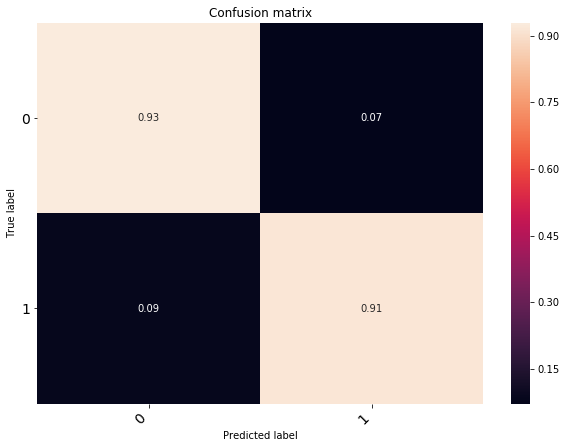

In [35]:
%matplotlib inline

import autodeploy as ad

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = model.predict_classes(X_test.values)
cm = confusion_matrix(list(y_test.reset_index(drop=True)), list(y_pred))

ad.print_confusion_matrix(cm, [0, 1], normalize=True)
# plt.show()

In [41]:
X_test.head(5)
y_pred[:5]

,x_1,x_2,x_3,x_4
6252,1.646629,0.811971,-0.712092,1.570961
4684,0.428770,-0.745024,-0.080931,-0.517712
1731,-0.989919,0.987401,0.266892,0.485329
4742,1.499358,-0.866558,-0.472959,-0.125622
4521,2.820048,0.346508,-1.105476,1.678765


array([[1],
       [1],
       [0],
       [1],
       [1]], dtype=int32)

# Generate another input distribution

In [9]:
new_path = '/tmp/new_data.csv'
generate_data(path=new_path, file_system='local',
                           n_samples=10000,n_features=4,
                            class_sep=1.0, n_informative=2,
                            n_redundant=1, random_state=1)


I0702 08:32:33.058906 140238163240320 <ipython-input-2-dcaddbcadd8c>:29] Dataset was generated successfully and saved in /tmp/new_data.csv 


        x_1       x_2       x_3       x_4  y
0 -1.505968 -0.895493  1.143011 -1.093964  0
1  2.099474 -0.654507  0.018392 -0.438753  1
2  0.322389 -0.351493 -1.441688 -0.326400  1
3 -0.909830  1.177889 -1.709902  1.113025  0
4 -0.937060  0.998497 -0.945329  0.924818  0


In [10]:
df_new = pd.read_csv(new_path)
X = df_new.loc[:, df_new.columns != 'y']
y = df_new['y']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
                        X, y, test_size=0.2, random_state=42)

In [11]:
test_acc = model.evaluate(X_test_new, y_test_new, verbose=2)
print('The model had a ACC on the test set of {0}'.format(round(test_acc[1], 3)))

The model had a ACC on the test set of 0.818


In [12]:
metric_model = dict()
y_pred = model.predict_classes(X_test_new.values)

cm = confusion_matrix(list(y_test_new.reset_index(drop=True)), list(y_pred))
cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

metric_model['confusion_matrix_normalized'] = cm_n
metric_model['confusion_matrix'] = cm
metric_model['accuracy'] = accuracy_score(y_pred, y_test_new)
# metric_model['estimator_classes'] = model.classes_.tolist()
# metric_model

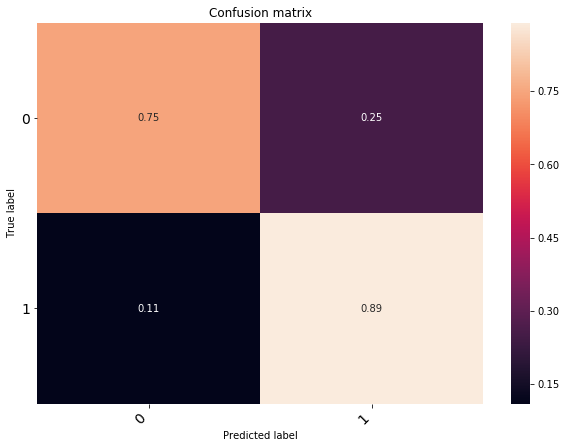

In [13]:
import autodeploy as ad

ad.print_confusion_matrix(metric_model['confusion_matrix'], [0, 1], normalize=True)
# plt.show()

# Interpretability

########## Comparing two numerical dataframes ##########

######## Kolmogorov-Smirnov test ########


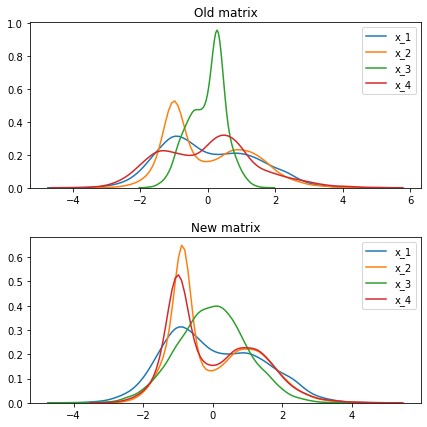

                x_1          x_2          x_3          x_4
p_value    0.999965  5.01237e-24  4.85352e-97  3.99241e-43
explain  Comparable    Different    Different    Different

######## Correlation matrix similarity test ########


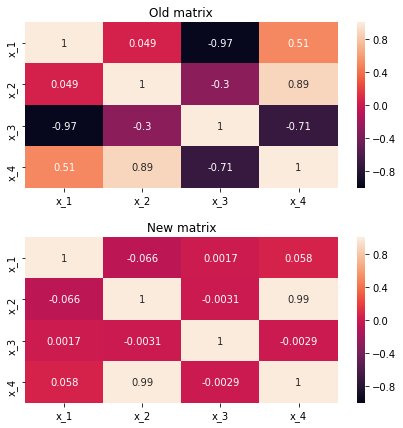

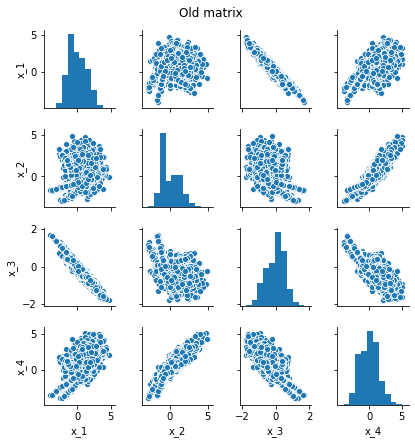

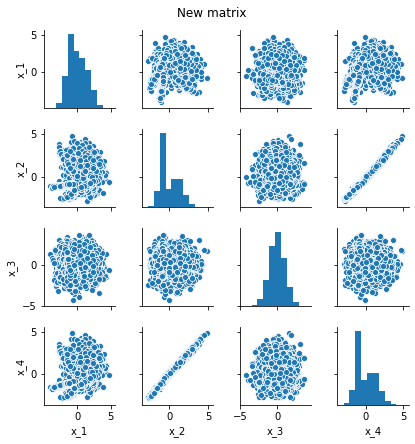

          x_1       x_2       x_3       x_4
x_1  0.000000 -0.016807 -0.966057  0.448367
x_2 -0.016807  0.000000  0.295798  0.106181
x_3 -0.966057  0.295798  0.000000  0.704046
x_4  0.448367  0.106181  0.704046  0.000000
                0               1               2         3
0        diagonal  diff direction  diff direction       bad
1  diff direction        diagonal             bad    medium
2  diff direction             bad        diagonal       bad
3             bad          medium             bad  diagonal


In [14]:
ad.overall_test(X_train, X_train_new, test=['ks', 'corr'], verbose=True)